# <center>Welcome to 21cmFirstCLASS Notebook #3!</center>
### <center>By J. Flitter and S. Libanore</center>

21cmFirstCLASS is an extension of the popular 21cmFAST code that interfaces with CLASS to generate initial conditions consistent with the input cosmological model. These initial conditions can be set during the time of recombination, allowing one to compute the 21cm signal (and its spatial fluctuations) throughout the dark ages, as well as in the proceeding cosmic dawn and reionization epochs, just like in the standard 21cmFAST.

#### Summary of previous notebooks
- In Notebook #1, you learned how to install 21cmFirstCLASS and its dependencies, how to run the code for basic settings, and how to plot easily the simulation outputs.

- In Notebook #2, you learned about the new physical features (in &Lambda;CDM cosmology) that have been introduced to 21cmFirstCLASS and how to restore conditions similar to the original 21cmFAST.

#### In this notebook you will learn how to...
- Run the code for beyond &Lambda;CDM cosmology, specifically for fuzzy dark matter (FDM) and scattering dark matter (SDM).

## Installation

In this tutorial we are going to run modified CLASS versions that support FDM and SDM physics. In order to distinguish between different CLASS versions, <b>it is important to modify the package's name during its installation</b>.

### AxiCLASS (for FDM)
For FDM, download AxiCLASS:
  ```python
  cd 21cmFirstCLASS
  git clone https://github.com/PoulinV/AxiCLASS AxiCLASS
  ```
Prior the installation of AxiCLASS, change the imported package's name to 'axiclassy' (instead of 'classy'). To do so, open AxiCLASS/python/setup.py and make the following changes in the file:
* At line 40 replace: classy_ext = Extension("classy",... -> classy_ext = Extension("axiclassy",...
* At line 50 replace: name='classy', -> name='axiclassy',

Then, return to the terminal and type
  ```python
  cd AxiCLASS/
  make
  ```
#### Note
If the compilation procedure fails, try to remove "-lgsl -lgslcbla" at line 166 in the Makefile.

### dmeff_CLASS (for SDM)
For SDM, download dmeff_CLASS:
  ```python
  cd 21cmFirstCLASS
  git clone -b dmeff https://github.com/kboddy/class_public.git dmeff_CLASS
  ```
Prior the installation of dmeff_CLASS, change the imported package's name to 'dmeff_classy' (instead of 'classy'). To do so, open dmeff_CLASS/python/setup.py and make the following changes in the file:
* At line 37 replace: classy_ext = Extension("classy",... -> classy_ext = Extension("dmeff_classy",...
* At line 46 replace: name='classy', -> name='dmeff_classy',

Then, return to the terminal and type
  ```python
  cd dmeff_CLASS/
  make
  ```

## General definitions

In [1]:
# Import the packages required for this tutorial

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

import py21cmfast as p21c # To run 21cmFirstCLASS (21cmFAST)
from py21cmfast import plotting # For plotting global signals, coeval boxes and lightcone boxes
import py21cmfast.power_spectrum as ps # Calculate power spectrum from the lightcone
from py21cmfast.inputs import global_params # Useful in this tutorial to plot the initial conditions for the simulation

In [2]:
# import dmeff_classy
# print(dmeff_classy.__version__)

It is VERY recommended for 21cmFirstCLASS users to have the 'latex' package installed in the same python environment where 21cmFirstCLASS is installed. <br>
If you have latex installed then you may run the next cell, otherwise do not run it as it will raise errors and no plots in this tutorial will be shown!

In [3]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts

Define the color palette (this combination is good for colorblindness).

In [4]:
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

## 1st run: &Lambda;CDM
The first simulation we shall perform is similar to the one we had in Notebook #1, that is under the assumption of &Lambda;CDM.

Before running the simulation we need to set its parameters. We begin with setting 'user_params'.

### Important Note!
To speed up the computation we use a rather small box with low resolution. Altough these settings are fine to obtain the correct global history, they are inadequate for studying the fluctuations of the box, or the power spectrum. Make sure to increase BOX_LEN and HII_DIM for reliable simulation of the power spectrum!

In [5]:
# Parameters related with the size of the simulation itself and with the kind of outputs required

user_params = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6} # whether or not to run CLASS prior to the 21cmFAST simulation.

Now we set the other parameters for the simulation.

In [6]:
# Parameters that set the physical processes the code accounts for

flag_options = {"USE_MINI_HALOS": False, } # if False, popIII stars are not included - Note: if set to True, the runtime increases significantly!

# Cosmological parameters in LCDM

cosmo_params = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                }

# Astrophysical parameters in a standard scenario
# some parameters require to input the log10 value

astro_params = {"F_STAR10": -1.25, # star formation efficiency (atomic cooling galaxies) for pivot mass 1e10 Msun (log10)
                "ALPHA_STAR": 0.5, # slope of the dependency of star formation efficiency on the host halo mass 
                "F_ESC10": -1.35, # escape fraction of Lyman photons into the IGM for pivot mass 1e10 Msun (log10)
                "ALPHA_ESC": -0.3, # slope of the dependency of escape fraction on the host halo mass 
                "L_X": 40.5, # X-ray luminosity (log10)
        
# popIII stars parameters -- use only if USE_MINI_HALOS = True    
                #"F_STAR7_MINI": -2.5, # star formation efficiency (molecular cooling galaxies) for pivot mass 1e7 Msun (log10)
                #"ALPHA_STAR_MINI": 0., # slope of the dependency of star formation efficiency on the host halo mass 
                #"F_ESC7_MINI": -1.35, # escape fraction of Lyman photons into the IGM for molecular cooling galaxies, assumed constant as function of the halo mass (log10)
                # "L_X_MINI": 40.5, # Xray luminosity 
}

global_quantities = ("brightness_temp", # brightness temperature
                     "J_Lya_box", # Lyman alpha flux 
                     "Tk_box", # baryon kinetic temperature
                     "T_chi_box", # SDM temperature
                     "V_chi_b_box") # Relative velocity between baryons and SDM 

lightcone_quantities = ("brightness_temp",) # brightness temperature

We now run 21cmFirstCLASS with the above settings.

In [7]:
lightcone_LCDM = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                    random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                    regenerate = True, # create new data even if cached are found
                                    write = False, # whether or no to save cached files
                                    user_params = user_params,
                                    astro_params = astro_params,
                                    flag_options = flag_options,
                                    cosmo_params = cosmo_params,
                                    global_quantities = global_quantities,
                                    lightcone_quantities = lightcone_quantities) ;

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|██████████████████████████████████| 84/84 [01:01<00:00,  1.36redshift/s]


Now evaluating tau to reionization and re-running CLASS...


Remember that in the default settings of 21cmFirstCLASS, CLASS runs before the 21cmFAST simulation, in order to generate the initial conditions for 21cmFAST (if you want to know more on new features of 21cmFirstCLASS in &Lambda;CDM - check out Notebook #2!).

We extract in the cell below the matter power spectrum for the above &Lambda;CDM simulation.

In [8]:
# Extract transfer functions and associated wavenumbers
k = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS))[1:] # 1/Mpc
T_m0_LCDM = np.array(global_params.T_M0_TRANSFER)[1:]

# Primordial curvature power spectrum
k_pivot = 0.05 # 1/Mpc
P_R = lightcone_LCDM.cosmo_params.A_s * pow(k/k_pivot, lightcone_LCDM.cosmo_params.POWER_INDEX-1.)

# Matter density power spectrum (at z=0)
P_m0_LCDM = 2.*np.pi**2 * P_R * T_m0_LCDM**2/k**3

## 2nd run: fuzzy dark matter (FDM)

Generally speaking, beyond &Lambda;CDM models can change the 21cm signal by one of the following three ways:
- by modifying the input matter power spectrum.
- by modifying the thermal and ionization histories.
- by modifying all the above.

We begin our first exploration of beyond &Lambda;CDM physics by looking at the first class of models mentioned above, which only affect the shape of the power spectrum. To do so, we adopt the fuzzy dark matter (FDM) model.

If fuzzy dark matter exists, it suppresses the matter power spectrum at small scales due to its tiny mass and wave-like nature. There are two parameters associated with this model: the FDM particle mass $m_\mathrm{FDM}$ and its fraction $f_\mathrm{FDM}$ of the total dark matter.

21cmFirstCLASS allows you to perform simulations that include the FDM component; to do so, it relies on AxiCLASS, which you installed at the beginning of this notebook. When the FUZZY_DM flag is set on True, the code runs axiclassy instead of the standard classy to compute the initial condition. In order to simulate FDM in 21cmFirstCLASS, you need to set the FUZZY_DM flag on true, as well as to specify the FDM mass and fraction.

#### Note
When running the next cell, you can ignore the "xwero" printout, as it is a debugging message from AxiCLASS.

In [8]:
# Include fuzzy dark matter in the simulation
user_params['FUZZY_DM'] = True

# Specify the FDM properties
cosmo_params['m_FDM'] = 24. # mass of the FDM particle. This is in fact -log_10(m_FDM/eV), thus we simulate here FDM with a mass of m_FDM=1e-24 eV.
cosmo_params['f_FDM'] = 1. # fraction of FDM. This is in fact -log_10(f_FDM), thus we simulate here FDM with a fraction of 10%.

lightcone_FDM = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                   random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                   regenerate = True, # create new data even if cached are found
                                   write = False, # whether or no to save cached files
                                   user_params = user_params,
                                   astro_params = astro_params,
                                   flag_options = flag_options,
                                   cosmo_params = cosmo_params,
                                   global_quantities = global_quantities,
                                   lightcone_quantities = lightcone_quantities) ;

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:33<00:00,  2.53redshift/s]


Now evaluating tau to reionization and re-running CLASS...


We also extract the matter power spectrum in the FDM universe we have simulated.

In [9]:
# Extract transfer function for FDM
T_m0_FDM = np.array(global_params.T_M0_TRANSFER)[1:]

# Matter density power spectrum (at z=0)
P_m0_FDM = 2.*np.pi**2 * P_R * T_m0_FDM**2/k**3

And now we compare the matter power spectra between the &Lambda;CDM and FDM scenarios. As clearly seen, FDM tends to suppress power on small scales.

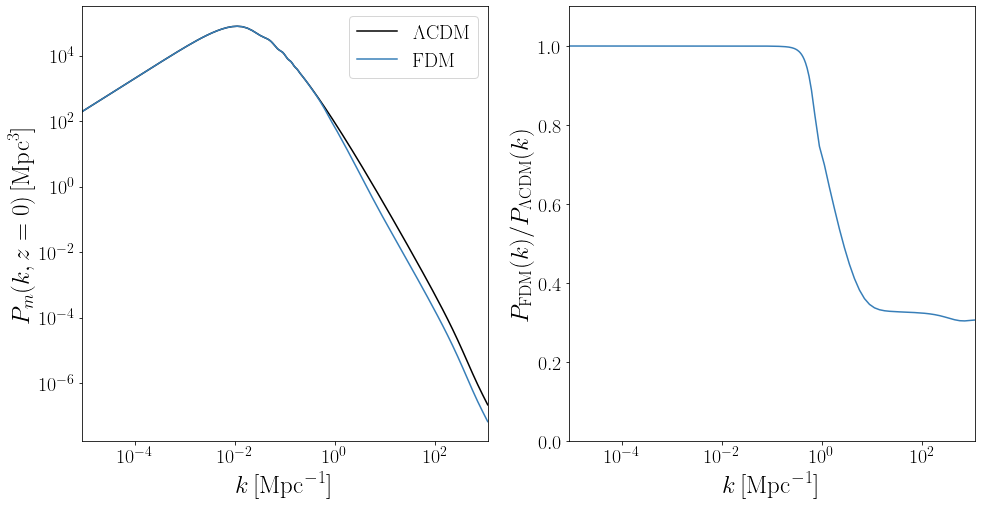

In [10]:
# Plot!
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].loglog(k,P_m0_LCDM,color='k',label=r'$\Lambda$CDM')
ax[0].loglog(k,P_m0_FDM,label='FDM')
ax[1].semilogx(k,P_m0_FDM/P_m0_LCDM)

# Prettify the plot
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[0].set_xlabel(xlabel=r'$k\,[\mathrm{Mpc}^{-1}]$',fontsize=25)
ax[0].set_ylabel(ylabel=r'$P_m(k,z=0)\,[\mathrm{Mpc}^3]$',fontsize=25)
ax[0].set_xlim([min(k),max(k)])
ax[0].legend(fontsize=20)

# Prettify the plot
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[1].set_xlabel(xlabel=r'$k\,[\mathrm{Mpc}^{-1}]$',fontsize=25)
ax[1].set_ylabel(ylabel=r'$P_\mathrm{FDM}(k)/P_\mathrm{\Lambda CDM}(k)$',fontsize=25)
ax[1].set_xlim([min(k),max(k)])
ax[1].set_ylim([0,1.1]) ;

Because power is suppressed in small scales, it is more difficult for halos at small scales to collapse and form stars inside. Therefore, the Ly&alpha; flux is smaller in FDM universe compared to &Lambda;CDM.

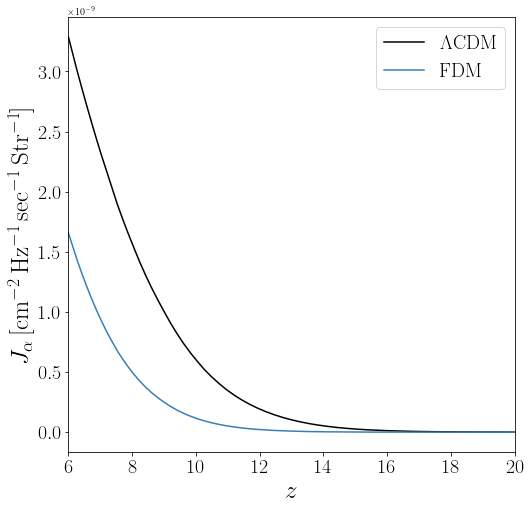

In [11]:
fig, ax = plotting.plot_global_history(lightcone_LCDM,kind='J_Lya_box',color='k',label=r'$\Lambda$CDM')
fig, ax = plotting.plot_global_history(lightcone_FDM,kind='J_Lya_box',ax=ax,label='FDM')
ax.set_xscale('linear')
ax.set_xlim([6,20]) ;

The attenuation in the Ly&alpha; flux can be viewed as if comsic dawn was delayed. Thus, in FDM universe the second absorption profile in the 21cm global signal shifts towards lower redshifts, while the global signal is completely unaffected during the dark ages.

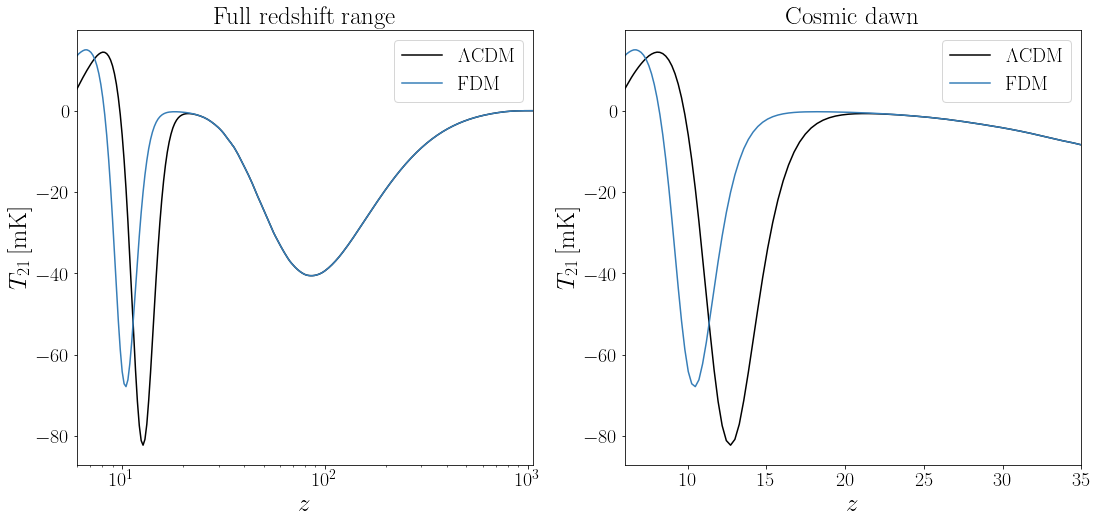

In [12]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
plotting.plot_global_history(lightcone_LCDM,ax=ax[0],color='k',label=r'$\Lambda$CDM')
plotting.plot_global_history(lightcone_FDM,ax=ax[0],label='FDM')
ax[0].set_title('Full redshift range',fontsize=25);

plotting.plot_global_history(lightcone_LCDM,ax=ax[1],color='k',label=r'$\Lambda$CDM')
plotting.plot_global_history(lightcone_FDM,ax=ax[1],label='FDM')
ax[1].set_title('Cosmic dawn',fontsize=25)
ax[1].set_xscale('linear')
ax[1].set_xlim([6,35]) ;

Once we have the lightcone objects for &Lambda;CDM and FDM, we can compute the 21cm power spectra in the two scnearios. We shall focus on the 21cm power spectrum to be detected by HERA, which is why we split the lightcones into chunks that correspond the HERA frequency bands.

In [36]:
# define the frequency range (50-250 MHz) and resolution (8 MHz) 
freq_bands_boundaries = np.arange(50.,225.+8.,8.); freq_bands_boundaries[-1] = 225.

# 21cm power spectrum in LCDM
power_spectrum_LCDM = ps.lightcone_power_spectrum(lightcone_LCDM,
                                                  freq_bands_boundaries = freq_bands_boundaries)

# # 21cm power spectrum in FDM
# power_spectrum_FDM = ps.lightcone_power_spectrum(lightcone_FDM,
#                                                  freq_bands_boundaries = freq_bands_boundaries)

And now we compare the power spectra.
### Important Note!
The following power spectrum plots are imprecise, as we have set a small box with very low resolution!
In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

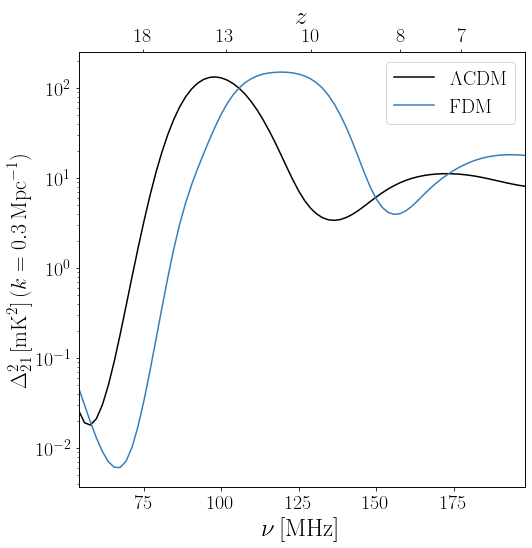

In [14]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_LCDM,
                                           k=0.3, # scale in units 1/Mpc
                                           smooth=True,
                                           x_kind = 'frequency',
                                           color='k',
                                           label = r'$\Lambda$CDM')

fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_FDM,
                                           k=0.3, # scale in units 1/Mpc
                                           smooth=True,
                                           x_kind = 'frequency',
                                           label = 'FDM',
                                           redshift_axis_on_top = True,
                                           ax=ax)

Here we see that the 21cm power spectrum in FDM has shifted to higher frequencies (lower redshifts). In particular, the &Lambda;CDM signal is stronger at $\nu\sim100\,\mathrm{MHz}$ while the FDM signal is stonger at $\nu\sim125\,\mathrm{MHz}$ due to the delay in the signal.

Remember that from now on the FUZZY_DM flag is set on True inside this notebook. If you want to disable the FDM computation, set it back to False.

## 3rd run: scattering dark matter (SDM)
Let's now explore a beyond LCDM model that affects the 21cm signal both due to changes in the initial power spectrum shape and because it affects the evolution of the thermal and reionization histories. For this, we choose to rely on the scattering dark matter (SDM) model.

In the scattering dark matter model, dark matter particles (often denoted by $\chi$) elastically scatter off standard model particles. As a consequence, heat flows from the hotter baryons to the colder SDM. In addition, the friction between the fluids results in a drag force that tends to lower the relative velocity as well as heating up both fluids.

The cross-section of the interaction is usually modeled as $\sigma=\sigma_{n}\left(v/c\right)^n$. Thus, the SDM model has four extra parameters to be determined:
1. The SDM particle mass $m_\chi$.
2. The SDM fraction $f_\chi$ from the total dark matter.
3. The power-law index of the cross section $n$.
4. The amplitude of the cross section $\sigma_n$.
5. In addition, different SDM models can differ by the target particles that interact with the SDM particles. This choice can change the interaction rate by orders of magnitude, depending on the mass and number density of the target particles.

21cmFirstCLASS allows you to perform simulations that include the SDM component; to do so, it relies on dmeff_CLASS, which you installed at the beginning of this notebook. When the SCATTERING_DM flag is set on True, the code runs dmeff_classy instead of the standard classy to compute the initial condition. Moreover, the implementation of the temperature evolution inside the modules of 21cmFirstCLASS runs differently when SDM is included. In order to simulate SDM in 21cmFirstCLASS, you need to set the SCATTERING_DM flag on true, as well as to specify all the above SDM parameters.

In [29]:
# Include scattering dark matter in the simulation
user_params['SCATTERING_DM'] = True
user_params['MANY_Z_SAMPLES_AT_COSMIC_DAWN'] = False
# user_params['FUZZY_DM'] = False # We need to tun off FDM as 21cmFirstCLASS currently doesn't support a mixed model of SDM and FDM. We can also leave that on True, and then an automatic logic will set FUZZY_DM to False.

# Specify the SDM properties
cosmo_params['m_chi'] = 6. # mass of the SDM particle. This is in fact log_10(m_chi/eV), thus we simulate here SDM with a mass of m_chi=1 MeV.
cosmo_params['f_chi'] = 0. # fraction of SDM. This is in fact -log_10(f_chi), thus we simulate here SDM with a fraction of 100%.
cosmo_params['SDM_INDEX'] = -4. # index of the SDM cross-section. Note that it doesn't have to be an integer!
cosmo_params['sigma_SDM'] = 42. # amplitude of SDM cross-section. This is in fact -log_10(sigma_SDM/cm^2), thus we simulate here SDM with a cross section of sigma = 1e-42*(v/c)^-4 cm^2.
# cosmo_params['N_dm'] = 1

# We also need to specify the target particles. 
# We have several options to do so. Valid input is either an integer or a string (lower case letters can be used as well)
# 1: BARYONS (all the baryons)
# 2: IONIZED (free protons and electrons)
# 3: HYDROGEN (hydrogen nuclei, neutralized or not)
# 4: PROTONS (free protons)
# 5: ELECTRONS (free electrons)
user_params['SDM_TARGET_TYPE'] = 'BARYONS'

lightcone_SDM = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                   random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                   regenerate = True, # create new data even if cached are found
                                   write = False, # whether or no to save cached files
                                   user_params = user_params,
                                   astro_params = astro_params,
                                   flag_options = flag_options,
                                   cosmo_params = cosmo_params,
                                   global_quantities = global_quantities,
                                   lightcone_quantities = lightcone_quantities) ;

You have set SCATTERING_DM to True but MANY_Z_SAMPLES_AT_COSMIC_DAWN is False!
For large SDM cross sections we need more redshift iterations during cosmic dawn in order to evolve the temperature correctly.
Consider setting MANY_Z_SAMPLES_AT_COSMIC_DAWN to True to avoid numerical errors.



Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|██████████████████████████████████| 84/84 [00:48<00:00,  1.74redshift/s]


Now evaluating tau to reionization and re-running CLASS...


Although higher cross section are possible, we note that large enough cross-sections may yield inconsistent results, mostly during the dark ages, due to uncalibrated collison coupling for temperatures below 1K (see more details in https://arxiv.org/pdf/2309.03942).

Notice the warning regarding the MANY_Z_SAMPLES_AT_COSMIC_DAWN flag. We will address it below.

Remember that when we specified the global quantities at the output, we also specified 'T_chi_box', for the SDM temperature $T_\chi$, and 'V_chi_b_box' for the bulk relative velocity between baryons and SDM $V_{\chi b}$. You can access these new global quantities from the usual global_quantities dictionary.

In [30]:
print(f'Stored global histories are {list(lightcone_SDM.global_quantities.keys())}')

Stored global histories are ['brightness_temp', 'J_Lya_box', 'Tk_box', 'T_chi_box', 'V_chi_b_box']


The direct interaction between SDM and baryons causes the temperature of the latter to significantly decrease.

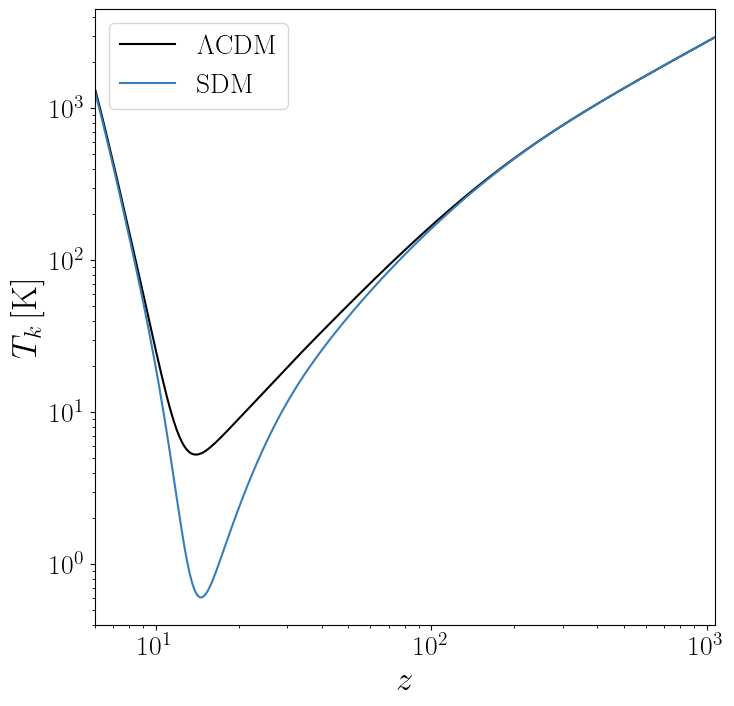

In [31]:
fig, ax = plotting.plot_global_history(lightcone_LCDM,kind='Tk_box',color='k',label=r'$\Lambda$CDM')
fig, ax = plotting.plot_global_history(lightcone_SDM,kind='Tk_box',ax=ax,label='SDM')
plt.savefig('Tk_n-4_m6_s-42.png',dpi=100)

It is also interesting to see how SDM temperature reacts to the interaction with the baryons.

In the settings we have chosen, there is a little effect on the SDM temperature as it is mostly cooled adiabatically by the expansion of the Universe. This is because the SDM particles outnumber the baryons: we chose a mass of $m_\chi=1\,\mathrm{MeV}$, while the typical baryons mass is $m_b\sim1\,\mathrm{GeV}\gg m_\chi$. Since we chose $f_\chi=100\%$ and $\Omega_c/\Omega_b$ is not too large, then $\rho_\chi=f_\chi\rho_c\sim\rho_b$ and thus $n_\chi=\rho_\chi/m_\chi\gg\rho_b/m_b=n_b$. Hence, increasing $m_\chi$ or decreasing $f_\chi$ is expected to have a larger effect on $T_\chi$.

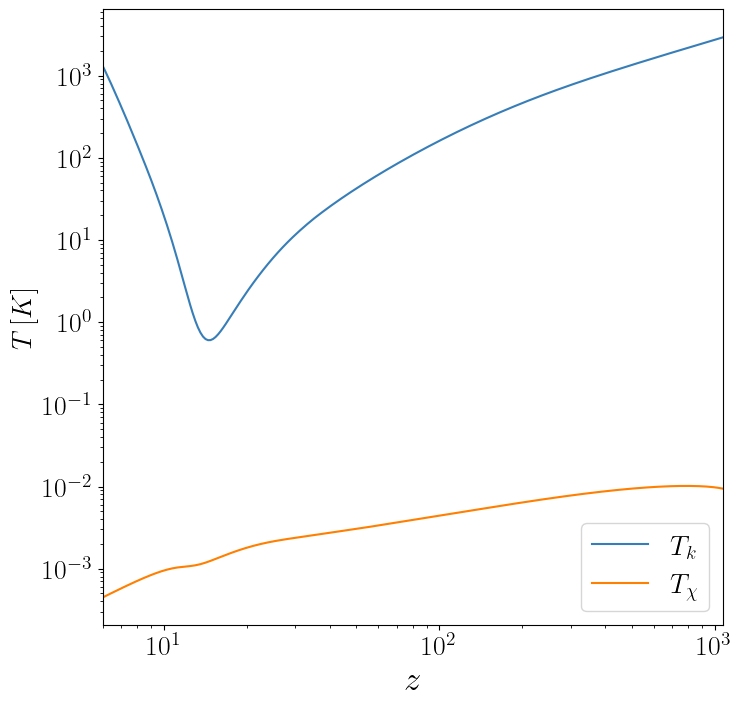

In [32]:
fig, ax = plotting.plot_global_history(lightcone_SDM,kind='Tk_box',label=r'$T_k$')
fig, ax = plotting.plot_global_history(lightcone_SDM,kind='T_chi_box',ax=ax,label=r'$T_\chi$')
ax.set_ylabel('$T\,\mathrm[K]$',fontsize=20);
plt.savefig('temps_n-4_m6_s-42.png',dpi=100)

Because $T_k$ reaches lower values when SDM is present, the deep in the brightness temperature can reach now much lower values, compared to &Lambda;CDM.

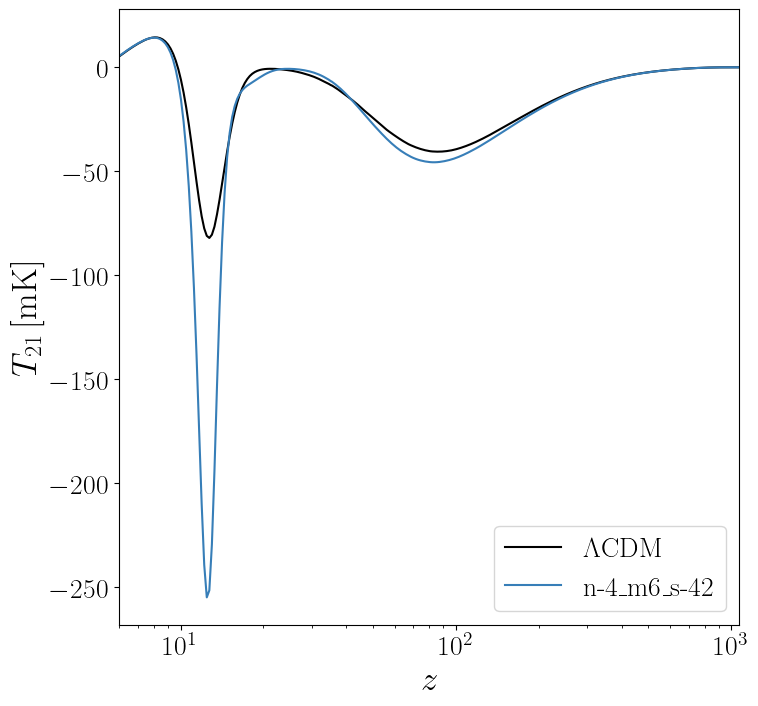

In [38]:
fig, ax = plotting.plot_global_history(lightcone_LCDM,color='k',label=r'$\Lambda$CDM')
fig, ax = plotting.plot_global_history(lightcone_SDM,ax=ax,label='n-4_m6_s-42')
plt.savefig('global_n-4_m6_s-42.png',dpi=100)

Notice that the blue curve at $z\sim20$ seems to be bit 'stiff'. We will fix that in the next run.

## 4th run: SDM (with more samples)
In order to fix the SDM curve during cosmic dawn, we set MANY_Z_SAMPLES_AT_COSMIC_DAWN = True.

In [18]:
user_params['MANY_Z_SAMPLES_AT_COSMIC_DAWN'] = True

lightcone_SDM2 = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                   random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                   regenerate = True, # create new data even if cached are found
                                   write = False, # whether or no to save cached files
                                   user_params = user_params,
                                   astro_params = astro_params,
                                   flag_options = flag_options,
                                   cosmo_params = cosmo_params,
                                   global_quantities = global_quantities,
                                   lightcone_quantities = lightcone_quantities) ;

Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|████████████████████████████████| 291/291 [02:26<00:00,  1.99redshift/s]


Now evaluating tau to reionization and re-running CLASS...


Now, you can see that in the last run we have 291 redshift iterations during cosmic dawn (while before we only had 84).

In the default settings, 21cmFirstCLASS adopts the same redshift sampling as in 21cmFAST, that is the n'th redshift sample is detemined from
\begin{equation}
\frac{1+z_{n-1}}{1+z_{n}} ={\rm ZPRIME\_STEP\_FACTOR}
\end{equation}

where ZPRIME_STEP_FACTOR is a parameter in global_params whose default is 1.02. Thus, the exact amount of redshift samples during cosmic dawn is given by $1+\mathrm{ceil}\{\log_{1.02}\left[\left(1+z_\mathrm{start}\right)/\left(1+z_\mathrm{end}\right)\right]\}$, which is 84 for $z_\mathrm{start}=35$ and $z_\mathrm{end}=6$. Note that in this logarithmic sampling, the step size $\Delta z=z_{n-1}-z_{n}$ is larger towards $z_\mathrm{start}=35$.

What we did in the last run was to increase the number of redshift iterations such that $\Delta z=0.1$ throughout cosmic dawn. Thus, the total number of redshift iterations is $1+\mathrm{ceil}\left[\left(z_\mathrm{start}-z_\mathrm{end}\right)/\Delta z\right]$, which is indeed 291.

This finer redshift sampling is necessary in SDM models in which the cross section is large enough to drop $T_k$ very rapidly, so the default redshift sampling of 21cmFAST is not sufficient for solving $T_k$ precisely.

In the cell below we compare the brightness temperature with and without the extra samples during cosmic dawn.

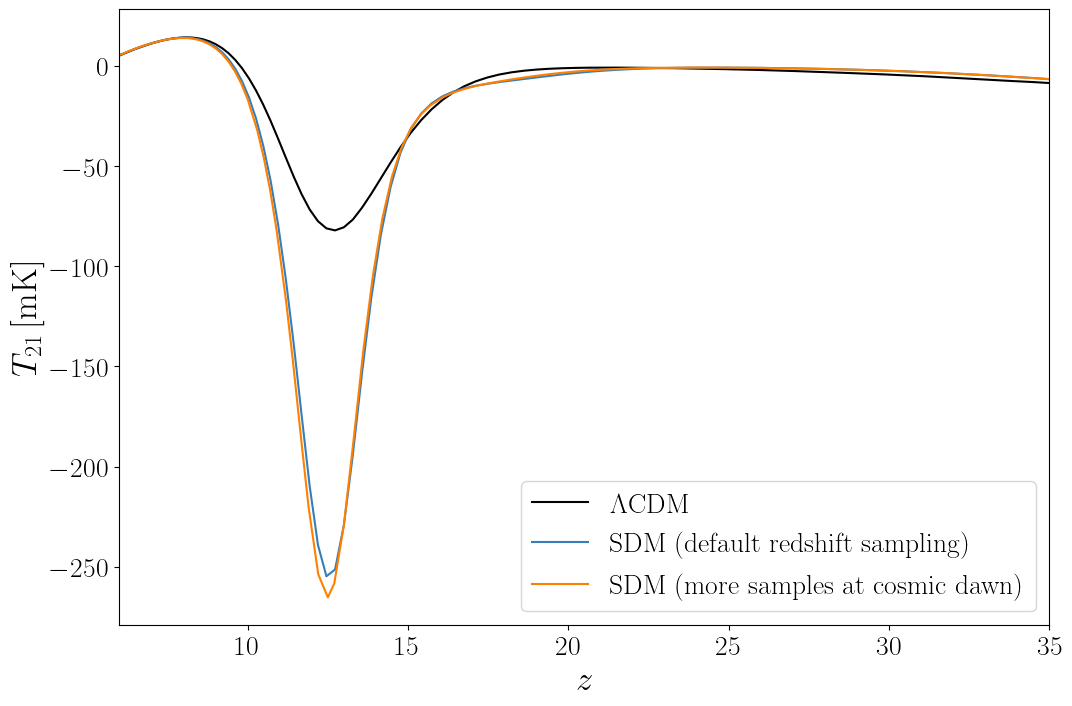

In [34]:
fig ,ax = plt.subplots(1,1,figsize=(12,8))
fig, ax = plotting.plot_global_history(lightcone_LCDM,ax=ax,color='k',label=r'$\Lambda$CDM')
fig, ax = plotting.plot_global_history(lightcone_SDM,ax=ax,label='SDM (default redshift sampling)')
fig, ax = plotting.plot_global_history(lightcone_SDM2,ax=ax,label='SDM (more samples at cosmic dawn)')

ax.set_xscale('linear')
ax.set_xlim([6,35]) ;

Here we see that not only the brightness temperature looks smoother (as we have more samples), but we also get a <b>different</b> curve when we have more samples. The reason for this is that errors in $T_k$ (due to insufficient $\Delta z$) manifest themselves mostly at the minimum of the brightness temperature (see a detailed explanation for that in Notebook #2).

Thus, we learn that large SDM cross sections require working with more redshift samples, thereby increasing the overall runtime. Smaller SDM cross sections though do not require having more redshift samples during cosmic dawn, which is why the default value of MANY_Z_SAMPLES_AT_COSMIC_DAWN is False.

#### Note
If you inspect the total number of redshift samples in the global quantitites, you will find it is not 173+291=464, but rather 173+84=257.

In [39]:
print(f'Length of the redshift array = {np.shape(lightcone_SDM2.node_redshifts)}')

Length of the redshift array = (257,)


The reason for this is because when MANY_Z_SAMPLES_AT_COSMIC_DAWN = True, 21cmFirstCLASS does not compute $x_\mathrm{HI}$ and $T_{21}$ at every iteration during cosmic dawn for which $T_k$ (or $T_s$) is computed. This is because the computation of $x_\mathrm{HI}$ can take a significant amount of time when USE_MINI_HALOS = True, and we only need the finer redshift sampling for getting a precise solution for $T_k$, not for the other fields.

Like in FDM, we can compute the 21cm power spectrum and see how it is affected by SDM.
### Important Note!
The following power spectrum plots are imprecise, as we have set a small box with very low resolution!
In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

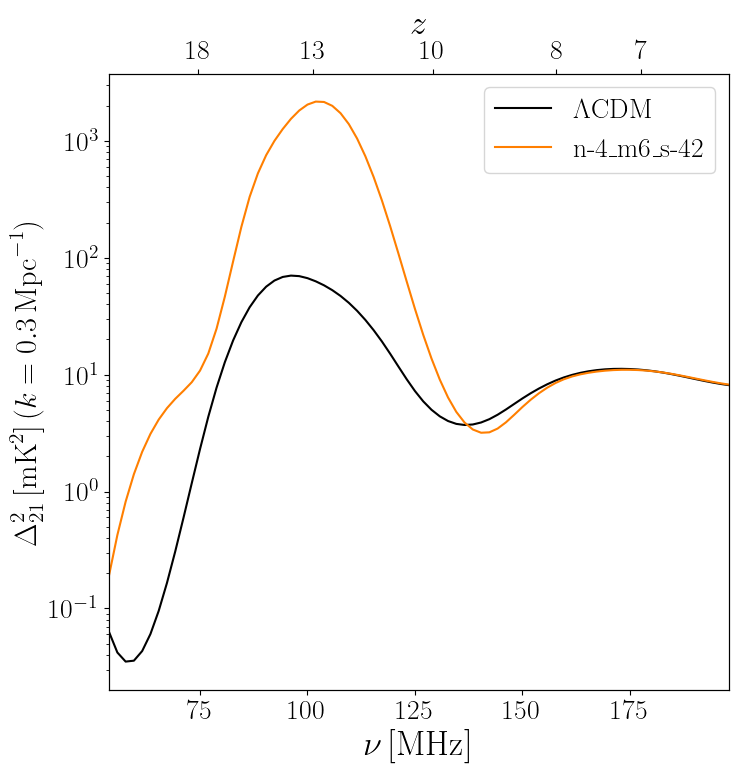

In [44]:
# 21cm power spectrum in SDM
power_spectrum_SDM = ps.lightcone_power_spectrum(lightcone_SDM2,
                                                 freq_bands_boundaries = freq_bands_boundaries)


# Plot the power spectra
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_LCDM,
                                           k=0.3, # scale in units 1/Mpc
                                           smooth=True,
                                           x_kind = 'frequency',
                                           color='k',
                                           label = r'$\Lambda$CDM')

fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_SDM,
                                           k=0.3, # scale in units 1/Mpc
                                           smooth=True,
                                           x_kind = 'frequency',
                                           color = colors[1],
                                           label = 'n-4_m6_s-42',
                                           redshift_axis_on_top = True,
                                           ax=ax) ;

plt.savefig('PS_n-4_m6_s-42.png',dpi=100)

We thus see that the deep absorption profile in SDM is also manifest through the 21cm power spectrum at $\nu\sim100\,\mathrm{MHz}$.

## 5th run: SDM (homogeneous initial $V_{\chi_b}$)
When turning on SDM with SCATTERIND_DM = True, 21cmFirstCLASS automatically sets on True some flags that their default value is False. One example is USE_CS_S_ALPHA.  

In [24]:
print(f'USE_CS_S_ALPHA in LCDM: {lightcone_LCDM.user_params.USE_CS_S_ALPHA}')
print(f'USE_CS_S_ALPHA in SDM: {lightcone_SDM2.user_params.USE_CS_S_ALPHA}')

USE_CS_S_ALPHA in LCDM: False
USE_CS_S_ALPHA in SDM: True


The meaning of this flag is that when SCATTERING_DM = True, 21cmFirstCLASS computes the correction factor $\tilde S_\alpha$ for the WF coupling from the analytical formula of Chuzhoy & Shapiro, rather than using the fit of Hirata that is found in public 21cmFAST. The reason for this is that Hirata's fit breaks at low temperatures, while the formula of Chuzhoy & Shapiro doesn't, and it agrees well with Hirata's fit at high temperatures (see more details on that in Appendix D in https://arxiv.org/pdf/2309.03942).

Another flag that is automatically set to True when SCATTERIND_DM = True is USE_SDM_FLUCTS.

In [25]:
print(f'USE_SDM_FLUCTS in SDM: {lightcone_SDM2.user_params.USE_SDM_FLUCTS}')

USE_SDM_FLUCTS in SDM: True


In order to understand the meaning of this flag, let's rerun 21cmFirstCLASS one again, this time when this flag is False.

In [26]:
user_params['USE_SDM_FLUCTS'] = False

lightcone_SDM3 = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                   random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                   regenerate = True, # create new data even if cached are found
                                   write = False, # whether or no to save cached files
                                   user_params = user_params,
                                   astro_params = astro_params,
                                   flag_options = flag_options,
                                   cosmo_params = cosmo_params,
                                   global_quantities = global_quantities,
                                   lightcone_quantities = lightcone_quantities) ;

You have set SCATTERING_DM to True but USE_SDM_FLUCTS to False!
This means that the initial V_chi_b box is homogeneous.
Set USE_SDM_FLUCTS to True to have initial inhomogeneous V_chi_b box.



Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|███████████| 291/291 [01:52<00:00,  2.58redshift/s]


Now evaluating tau to reionization and re-running CLASS...


As the warning explains, when USE_SDM_FLUCTS is False, the initial $V_{\chi b}$ box is homogeneous!

Let us see what is the effect of this in the evolution of $T_k$.

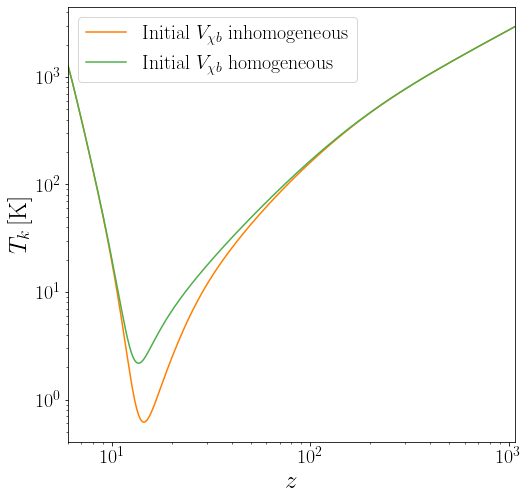

In [27]:
fig, ax = plotting.plot_global_history(lightcone_SDM2,kind='Tk_box',color=colors[1],label=r'Initial $V_{\chi b}$ inhomogeneous')
fig, ax = plotting.plot_global_history(lightcone_SDM3,kind='Tk_box',color=colors[2],ax=ax,label=r'Initial $V_{\chi b}$ homogeneous')

We see that an initial homogeneous $V_{\chi b}$ box seems to yield a different evolution for $T_k$! This also affects the brightness temperture.

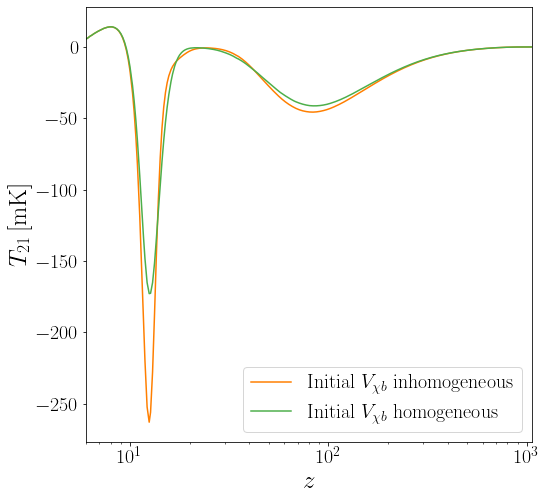

In [28]:
fig, ax = plotting.plot_global_history(lightcone_SDM2,color=colors[1],label=r'Initial $V_{\chi b}$ inhomogeneous')
fig, ax = plotting.plot_global_history(lightcone_SDM3,color=colors[2],ax=ax,label=r'Initial $V_{\chi b}$ homogeneous')

Interestingly, the inhomogeneity in the initial $V_{\chi b}$ box seems to matter!

The reason for that is because SDM is a non-linear model in its nature; the interaction rate $\propto v\sigma=\sigma_n\left(v/c\right)^{n+1}$ is not linear in $v$ for $n\neq0$ (while for $n=-1$ it is independent of the velocity). Thus, small linear fluctuations in $V_{\chi_b}$ result in non-linear large fluctuations in the interaction rate, which become manifest as non-linear large fluctuations in the temperature. When taking the mean of the box, these large temperature fluctuations do not cancel!

For that reason, USE_SDM_FLUCTS is True by default when SDM is simulated in 21cmFirstCLASS.

For future reference, we now extract the power spectrum of $V_{\chi b}$ at kinematic decoupling.

In [29]:
# Extract V_chi_b transfer function at kinematic decoupling
T_v_chi_b_kin = np.array(global_params.T_V_CHI_B_ZHIGH_TRANSFER)[1:]

# Dimensionless baryon-SDM relative velocity power spectrum at kinematic decoupling
Delta_v_chi_b_kin_sq = P_R * T_v_chi_b_kin**2

## 6th run: &Lambda;CDM (with small SDM cross section)
We can recover &Lambda;CDM from SDM if we either take the cross section of the interaction to be very small, or by taking the SDM fraction $f_\chi$ to be small. Below we take the former option.

In [30]:
cosmo_params['sigma_SDM'] = 44. # This means we set the SDM cross section is sigma = 1e-44 (v/c)^-4 cm^2

lightcone_LCDM2 = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                                     random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                                     regenerate = True, # create new data even if cached are found
                                     write = False, # whether or no to save cached files
                                     user_params = user_params,
                                     astro_params = astro_params,
                                     flag_options = flag_options,
                                     cosmo_params = cosmo_params,
                                     global_quantities = global_quantities,
                                     lightcone_quantities = lightcone_quantities) ;

You have set SCATTERING_DM to True but USE_SDM_FLUCTS to False!
This means that the initial V_chi_b box is homogeneous.
Set USE_SDM_FLUCTS to True to have initial inhomogeneous V_chi_b box.



Now running CLASS...
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|███████████| 291/291 [01:49<00:00,  2.66redshift/s]


Now evaluating tau to reionization and re-running CLASS...


Let us plot now the bulk relative velocity $V_{\chi b}$ for the last three simulations we performed.

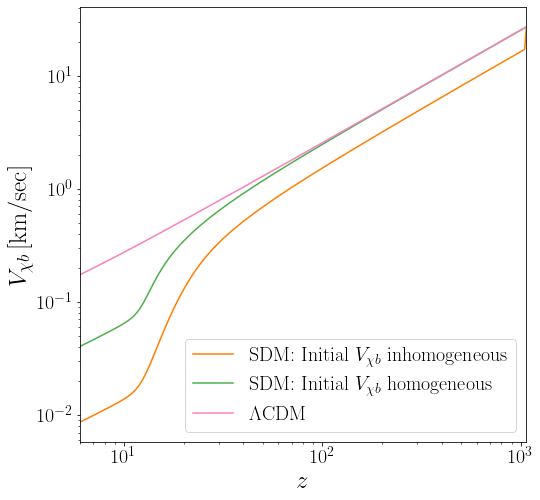

In [31]:
fig, ax = plotting.plot_global_history(lightcone_SDM2,kind='V_chi_b_box',color=colors[1],label=r'SDM: Initial $V_{\chi b}$ inhomogeneous')
fig, ax = plotting.plot_global_history(lightcone_SDM3,kind='V_chi_b_box',color=colors[2],ax=ax,label=r'SDM: Initial $V_{\chi b}$ homogeneous')
fig, ax = plotting.plot_global_history(lightcone_LCDM2,kind='V_chi_b_box',color=colors[3],ax=ax,label=r'$\Lambda$CDM')

This plot is interesting!

First, we see indeed that by taking a small cross-section, the SDM effectively becomes CDM and so the bulk relative velocity $V_{cb}$ scales like $\left(1+z\right)$, this is a well known result in &Lambda;CDM.

Second, by comparing the green and pink curves we see that indeed the direct interaction between SDM particles and baryons tends to lower the relative velocity due to the mutual drag force that the two fluids apply on each other.

Third, we see that the orange curve begins way off from the green curve. Why is that? This is because for the orange curve, the initial $V_{\chi b}$ box is Maxwellian with an rms of

\begin{equation}
\langle V_{\chi b}^2\rangle^{1/2}=\int_{k_\mathrm{min}}^{k_\mathrm{max}}\frac{dk}{k}\Delta^2_{V_{\chi b}}\left(k,z=z_\mathrm{kin}\right)
\end{equation}

where $k_\mathrm{min}=2\pi/\mathrm{BOX\_LEN}$ and $k_\mathrm{max}=k_\mathrm{min}\times\mathrm{HII\_DIM}$. For a Maxwellian box, the mean of the box is then
\begin{equation}
\langle V_{\chi b}\rangle=\sqrt{\frac{8}{3\pi}}\cdot\langle V_{\chi b}^2\rangle^{1/2}\approx0.92\cdot\langle V_{\chi b}^2\rangle^{1/2}
\end{equation}

Thus, we see that if BOX_LEN and HII_DIM are not large enough, the mean of the initial $V_{\chi b}$ box does not agree with the global value that is obtained by taking $k_\mathrm{min}=0$, $k_\mathrm{max}=\infty$ (this is the initial starting point for the 'homogeneous' green curve).

How big should BOX_LEN and HII_DIM be in order to converge with the global value? We can estimate that from looking in the power spectrum of $V_{\chi b}$ at kinematic decoupling.

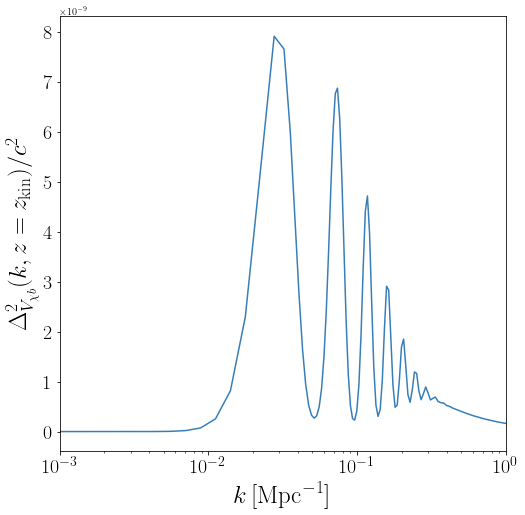

In [32]:
# Plot!
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.semilogx(k,Delta_v_chi_b_kin_sq)

# Prettify the plot
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlabel(xlabel=r'$k\,[\mathrm{Mpc}^{-1}]$',fontsize=25)
ax.set_ylabel(ylabel=r'$\Delta^2_{V_{\chi b}}(k,z=z_\mathrm{kin})/c^2$',fontsize=25)
ax.set_xlim([1e-3,1.]);

Most of the power lies between $k_\mathrm{min}\sim0.01\,\mathrm{Mpc}^{-1}$ and $k_\mathrm{max}\sim0.4\,\mathrm{Mpc}^{-1}$, implying that agreement with the global value requires $\mathrm{BOX\_LEN}>628$ and $\mathrm{HII\_DIM}>40$.

Do we really need to have a box size that is greater than 628 Mpc in order to simulate SDM preciely? Remember that the goal of 21cmFirstCLASS is to simulate the 21cm signal as can be probed by a an experiment/survey. If our survey cannot access such large scales (e.g. HERA, see Notebook #4), then it's okay if we simulate a "small" patch of the Universe whose size matches the volume of the survey.

## Other beyond &Lambda;CDM models

In this notebook you learned how to run 21cmFirstCLASS to simulate FDM or SDM. You are encouraged to play more with the FDM and SDM parameters and see how they affect the 21cm signal!

Currently, 21cmFirstCLASS only supports these two models as beyond &Lambda;CDM models. However, studying other models with 21cmFirstCLASS is (relatively) easy as it does not require too much modifications of the code.

1. If your model modifies the matter power spectrum, you can account for it by simply switching to a modified CLASS version that simulates your model (with some adjustments made in the generate_ICs.py module). Prior installing your modified CLASS version, we highly recommend to change the imported package name (see installation instructions at begining of this notebook) so 21cmFirstCLASS can distinguish between your CLASS version and other CLASS versions used by the code.
2. If your model also modifies the thermal and reionization history of the Universe, you would need to modify the differntial equations for $T_k$ and $x_e$ found in SpinTemperatureBox.c.

Once you do that (with some other special modifcations that your model might require), you're done! The simulation is self-consistent!

## Great, you reached the end of Notebook #3!

If you want to learn more about 21cmFirstCLASS and its application, you can continue with...

- Notebook #4 , to study the detectability of the 21cm power spectrum with upcoming experiments


#### If you have questions or you find bugs, feel free to email us!
jordanf@post.bgu.ac.il

libanore@bgu.ac.il